## Identifiability Test of Linear VAE on Synthetic Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
from ltcl.datasets.sim_dataset import SimulationDataset
from ltcl.modules.linear_vae import AfflineVAESynthetic
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")
latent_size = 8

In [4]:
data = SimulationDataset(directory = '/home/cmu_wyao/projects/data/', 
                         transition='linear_nongaussian')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [5]:
model = AfflineVAESynthetic(latent_size,latent_size,2).to(device)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:159: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


### Warm start spline flow

Do not run this block if already warm-started

In [6]:
batch_size = 64
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.spline.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 8
#     y_t = torch.normal(0, 1, size=(batch_size, latent_size))
    y_t = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size))
    dataset = y_t.to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = model.spline(dataset)
    logp = model.spline.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()
# This checkpoint will be loaded in lvae.py
torch.save(model.spline.state_dict(), "/home/cmu_wyao/spline.pth")

### Load model checkpoint

In [15]:
model = model.load_from_checkpoint("/data/datasets/logs/cmu_wyao/linear_vae_2lag/lightning_logs/version_1/checkpoints/epoch=99-step=777399.ckpt",
                                   input_dim = latent_size, z_dim=latent_size, lag=2)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:159: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [16]:
model.eval()

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=16, bias=True)
    )
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=8, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (trans_func): GroupLinearLayer()
  (spline): ComponentWiseSpline()
)

In [17]:
model.to('cpu')

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=16, bias=True)
    )
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=8, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (trans_func): GroupLinearLayer()
  (spline): ComponentWiseSpline()
)

### Compute permutation and sign flip

In [5]:
for batch in train_loader:
    break
batch_size = batch['xt'].shape[0]

In [22]:
        xt, xt_ = batch["xt"], batch["xt_"]
        batch_size, _, _  = xt.shape
        x = torch.cat((xt, xt_), dim=1)
        x = x.reshape(-1, 8)

In [23]:
x.shape

torch.Size([38400, 8])

In [24]:
xt.shape

torch.Size([12800, 2, 8])

In [25]:
x[2]

tensor([-0.0234, -1.2354, -0.4770,  0.3210, -0.5832, -1.3394,  0.5255, -0.4776])

In [26]:
xt

tensor([[[ 0.6482,  0.2901, -0.1813,  ..., -0.1797, -0.4811, -1.0145],
         [-0.1597, -0.0031, -0.0450,  ...,  0.2689,  0.1182, -0.1993]],

        [[-0.2293, -0.2498, -0.0347,  ..., -0.0022,  0.0286, -0.4724],
         [-0.2541, -0.0084, -0.4339,  ...,  0.4693,  0.5151, -0.2114]],

        [[ 0.1954,  0.4716,  0.8327,  ..., -0.0061, -0.2273, -0.8610],
         [ 0.7072, -0.0482,  0.0227,  ...,  0.2404,  0.2066, -0.8135]],

        ...,

        [[-0.6558,  0.3324, -0.4734,  ...,  0.1756, -0.1660, -0.1726],
         [ 0.9492, -0.4410, -0.6514,  ...,  0.5852,  0.8593, -1.6830]],

        [[-0.1949,  0.3032, -0.0323,  ...,  0.0604,  0.1900, -0.3489],
         [-0.9274, -0.3641, -0.7880,  ...,  0.8333,  0.3401, -0.7483]],

        [[ 0.0249, -0.5494, -0.0101,  ...,  0.3308, -0.0041, -0.3145],
         [-0.6503,  0.3400, -0.5801,  ...,  0.2249, -0.3785, -0.8198]]])

In [27]:
x.view(batch_size, -1, 8)[:,:-1,:]

tensor([[[ 0.6482,  0.2901, -0.1813,  ..., -0.1797, -0.4811, -1.0145],
         [-0.1597, -0.0031, -0.0450,  ...,  0.2689,  0.1182, -0.1993]],

        [[-0.2293, -0.2498, -0.0347,  ..., -0.0022,  0.0286, -0.4724],
         [-0.2541, -0.0084, -0.4339,  ...,  0.4693,  0.5151, -0.2114]],

        [[ 0.1954,  0.4716,  0.8327,  ..., -0.0061, -0.2273, -0.8610],
         [ 0.7072, -0.0482,  0.0227,  ...,  0.2404,  0.2066, -0.8135]],

        ...,

        [[-0.6558,  0.3324, -0.4734,  ...,  0.1756, -0.1660, -0.1726],
         [ 0.9492, -0.4410, -0.6514,  ...,  0.5852,  0.8593, -1.6830]],

        [[-0.1949,  0.3032, -0.0323,  ...,  0.0604,  0.1900, -0.3489],
         [-0.9274, -0.3641, -0.7880,  ...,  0.8333,  0.3401, -0.7483]],

        [[ 0.0249, -0.5494, -0.0101,  ...,  0.3308, -0.0041, -0.3145],
         [-0.6503,  0.3400, -0.5801,  ...,  0.2249, -0.3785, -0.8198]]])

In [20]:
x_recon, mu, logvar, z = model.forward(batch)

In [21]:
x_recon.shape

torch.Size([38400, 8])

In [22]:
x_recon, mu, logvar, z = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['yt'][:,0,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [2 5 3 4 7 6 1 0]
Sign Flip: [ 1. -1. -1.  1.  1.  1.  1. -1.]


Text(0.5, 1.0, 'MCC=0.98')

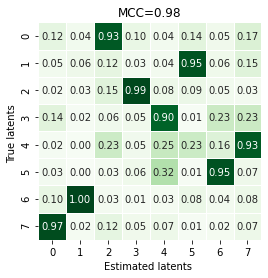

In [23]:
fig = plt.figure(figsize=(4,4))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=0.98")

In [24]:
# Permute column here
mu = mu[:,:,col_ind]
# Flip sign here
mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,latent_size)
mu = -mu

Text(0.5, 1.0, 'Current latent variable $z_t$')

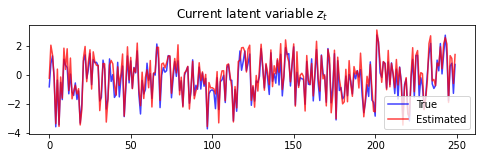

In [25]:
fig = plt.figure(figsize=(8,2))
col = 0
plt.plot(mu[:250,-1,col].detach().cpu().numpy(), color='b', label='True', alpha=0.75)
plt.plot(batch['yt_'].squeeze()[:250,col].detach().cpu().numpy(), color='r', label="Estimated", alpha=0.75)
plt.legend()
plt.title("Current latent variable $z_t$")

Text(0.5, 1.0, 'Past latent variable $z_l$')

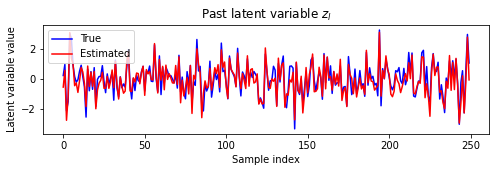

In [26]:
fig = plt.figure(figsize=(8,2))
col = 3
l = 1
plt.plot(batch['yt'].squeeze()[:250,l,col].detach().cpu().numpy(), color='b', label='True')
plt.plot(mu[:,:-1,:][:250,l,col].detach().cpu().numpy(), color='r', label="Estimated")
plt.xlabel("Sample index")
plt.ylabel("Latent variable value")
plt.legend()
plt.title("Past latent variable $z_l$")

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior')

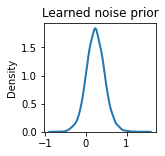

In [27]:
fig = plt.figure(figsize=(2,2))
eps = model.sample(batch["xt"].cpu())
eps = eps.detach().cpu().numpy()
component_idx = 1
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior")

### System identification (causal discovery)

In [41]:
from ltcl.modules.components.base import GroupLinearLayer
trans_func = GroupLinearLayer(din = 4, 
                              dout = 4,
                              num_blocks = 2,
                              diagonal = False)
opt = torch.optim.Adam(trans_func.parameters(),lr=0.01)
lossfunc = torch.nn.L1Loss()

In [42]:
max_iters = 2
counter = 0
for step in range(max_iters):
    for batch in train_loader:
        batch_size = batch['yt'].shape[0]
        x_recon, mu, logvar, z = model.forward(batch)
        mu = mu.view(batch_size, -1, 4)
        # Fix permutation before training
        mu = mu[:,:,col_ind]
        # Fix sign flip before training
        mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,4)
        mu = -mu
        pred = trans_func(mu[:,:-1,:]).sum(dim=1)
        true = mu[:,-1,:]
        loss = lossfunc(pred, true) #+ torch.mean(adaptive.lossfun((pred - true)))

        opt.zero_grad()
        loss.backward()
        opt.step()
        if counter % 100 == 0:
            print(loss.item())
        counter += 1

1.0879223346710205
0.05391911417245865


### Visualize causal matrix

In [28]:
B2 = model.trans_func.w[0][col_ind][:, col_ind].detach().cpu().numpy()
B1 = model.trans_func.w[1][col_ind][:, col_ind].detach().cpu().numpy()
B1 = B1 * mask.reshape(1,-1) * (-1*mask).reshape(-1,1)
B2 = B2 * mask.reshape(1,-1) * (-1*mask).reshape(-1,1)

In [29]:
BB2 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W1.npy")

In [30]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0.5, 1.0, 'Affline VAE + Spline flow')

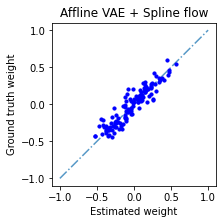

In [31]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(pred, true, s=10, cmap=plt.cm.coolwarm, zorder=10, color='b')
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")
ax.set_title("Affline VAE + Spline flow")

In [32]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [33]:
am2 = amari_distance(np.linalg.inv(B2) @ BB2)
am1 = amari_distance(np.linalg.inv(B1) @ BB1)
print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.3825880148184459, 0.2762852410244584)
